In [2]:
% matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from snntoolbox.config import update_setup

settings = {'path_wd': '/home/rbodo/.snntoolbox/data/roshambo',
            'dataset_path': '/home/rbodo/.snntoolbox/Datasets/roshambo',
            'dataset_format': 'npz',
            'filename_ann': 'NullHop',
            'model_lib': 'caffe',
            'evaluateANN': False,
            'normalize': True,
            'convert': True,
            'simulate': True,
            'simulator': 'INI',
            'duration': 30,
            'dt': 1,
            'batch_size': 50,
            'verbose': 3,
            'num_to_test': 15850,
            'runlabel': '01',
            'percentile': 100,
            'softmax_to_relu': True,
            'reset': 'Reset by subtraction',
            'input_rate': 1000
            }

update_setup(settings)

True

In [4]:
from snntoolbox.config import settings
T = int(settings['duration'] / settings['dt'])
L = 10  # num layers, excluding output layer.

# For frame input:
s = np.empty((settings['num_to_test'], L, T))
for batch_idx in range(int(settings['num_to_test']/settings['batch_size'])):
    # Insert batch of layer-spikecounts over time, shape (batch, L, T)
    s[batch_idx*settings['batch_size']: (batch_idx+1)*settings['batch_size']] = \
        np.load(os.path.join(settings['log_dir_of_current_run'], 'spikecounts', str(batch_idx) + '_l.npz'))['layer_spike_counts'][:, :-1, :]
s_samplemean = np.mean(s, axis=0)  # Averaged across samples, shape (L, T)
s_samplestd = np.std(s, axis=0)  # Samples contribute main part of variation. Activity in layers is fairly similar. 
s_layermean = np.mean(s, axis=1)  # Averaged across layers, shape (num_samples, T)
s_layerstd = np.std(s, axis=1)
s_mean = np.mean(s, axis=(0, 1))
s_std = np.std(s, axis=(0, 1))

# For Poisson input:
s_poisson = np.empty((settings['num_to_test'], L, T))
for batch_idx in range(50):#int(settings['num_to_test']/settings['batch_size'])):
    # Insert batch of layer-spikecounts over time, shape (batch, L, T)
    s_poisson[batch_idx*settings['batch_size']: (batch_idx+1)*settings['batch_size']] = \
        np.load(os.path.join(settings['path_wd'], 'log', 'gui', '04', 'spikecounts', str(batch_idx) + '_l.npz'))['layer_spike_counts'][:, :-1, :]
s_samplemean_poisson = np.mean(s_poisson, axis=0)  # Averaged across samples, shape (L, T)
s_samplestd_poisson = np.std(s_poisson, axis=0)  # Samples contribute main part of variation. Activity in layers is fairly similar. 
s_layermean_poisson = np.mean(s_poisson, axis=1)  # Averaged across layers, shape (num_samples, T)
s_layerstd_poisson = np.std(s_poisson, axis=1)
s_mean_poisson = np.mean(s_poisson, axis=(0, 1))
s_std_poisson = np.std(s_poisson, axis=(0, 1))

n = np.array([16*60*60, 16*30*30, 32*28*28, 32*14*14, 64*12*12, 64*6*6, 128*4*4, 128*2*2, 128*2*2, 128*1*1, 4])  # Number of neurons per layer
fin = np.array([1*5*5, 0, 16*3*3, 0, 32*3*3, 0, 64*3*3, 0, 128*1*1, 0, 128])  # fan-in per layer: num_input_channels * kernel_x * kernel_y. Pooling layers are not counted.
fout = np.array([1, 32*3*3, 1, 64*3*3, 1, 128*3*3, 1, 128*1*1, 1, 4])  # fan-out per layer. MaxPooling costs one addition per spike to estimate the firing rates.

In [5]:
num_input_neurons = 1*64*64  # num_channels*num_rows*num_cols
mean_input_activation = 0.075524298931175432  # mean(x_test)
std_input_activation = 0.20820052626306976  # std(x_test)
firing_prob = settings['input_rate']/1000  # == 1
mean_input_rate = num_input_neurons * mean_input_activation * firing_prob
std_input_rate = num_input_neurons * std_input_activation * firing_prob
sin_t = [(t+1) * mean_input_rate for t in range(T)]  # Input spikes vs time
sout_t = s_samplemean[-1]  # Output spikes vs time

In [6]:
# Error and number of operations in standard ANN
err_ANN = 0.1
c_ANN = np.dot(n, fin) * 2  # Double to get number of operations from MACs

# Error and number of operations in ANN on NullHop accelerator
sparsity = 0.52
uncertainty = 0.05
err_NHP = 0.1
c_NHP = c_ANN * sparsity
std_c_NHP = c_NHP * uncertainty

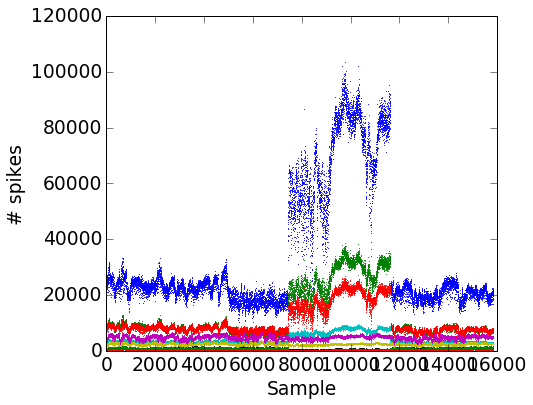

In [7]:
plt.plot(s[:, :, -1], '.', markersize=1)
plt.xlabel('Sample')
plt.ylabel('# spikes')

The high activity occurs in part of the background samples of the data set, where the whole camera is tilted and every pixel is active, instead of just an object in the center.

Class label indices: {'0': 'paper', '1': 'scissors', '2': 'rock', '3': 'background'}


Class boundaries: {'0': 0, '2': 4997, '3': 7435, '1': 11633}

In [8]:
num_computations = np.array([si * fi + fin[0] * n[0] for si, fi in zip(s_samplemean, fout)])  # Shape (L, T)
num_computations_poisson = np.array([si * fi + 16*5*5*mean_input_rate for si, fi in zip(s_samplemean_poisson, fout)])

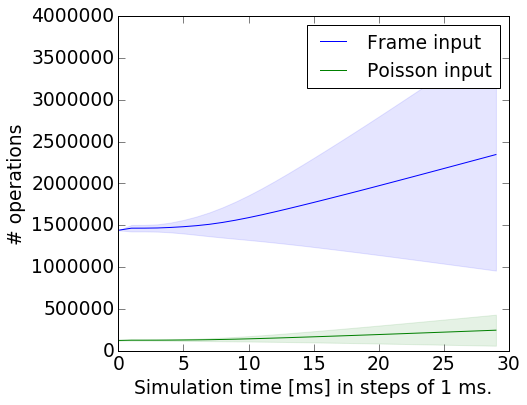

In [9]:
mean_c_t = np.mean(num_computations, axis=0)
std_c_t = np.std(num_computations, axis=0)
mean_c_t_poisson = np.mean(num_computations_poisson, axis=0)
std_c_t_poisson = np.std(num_computations_poisson, axis=0)
time = np.arange(0, settings['duration'], settings['dt'])
plt.plot(time, mean_c_t, color='blue', label='Frame input')
plt.fill_between(time, mean_c_t-std_c_t, mean_c_t+std_c_t, alpha=0.1, color='blue')
plt.plot(time, mean_c_t_poisson, color='green', label='Poisson input')
plt.fill_between(time, mean_c_t_poisson-std_c_t_poisson, mean_c_t_poisson+std_c_t_poisson, alpha=0.1, color='green')
plt.ylabel('# operations')
plt.xlabel('Simulation time [ms] in steps of {} ms.'.format(settings['dt']))
plt.legend()

In [10]:
# Batch-averaged error vs time. Shape (num_batches, T)
error_t = 100 * np.load(os.path.join(settings['log_dir_of_current_run'], 'net_top1err_t.npz'))['net_top1err_t']
mean_error_t = np.mean(error_t, axis=0)
std_error_t = np.std(error_t, axis=0)

# For Poisson input
error_t_poisson = 100 * np.load(os.path.join(settings['path_wd'], 'log', 'gui', '04', 'net_top1err_t.npz'))['net_top1err_t']
mean_error_t_poisson = np.mean(error_t_poisson, axis=0)
std_error_t_poisson = np.std(error_t_poisson, axis=0)

FileNotFoundError: [Errno 2] No such file or directory: '/home/rbodo/.snntoolbox/data/roshambo/log/gui/04/net_top1err_t.npz'

NameError: name 'mean_error_t_poisson' is not defined

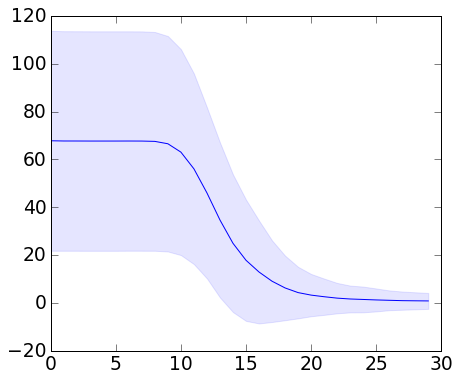

In [11]:
plt.plot(time, mean_error_t, color='blue', label='Frame input')
plt.fill_between(time, mean_error_t-std_error_t, mean_error_t+std_error_t, alpha=0.1, color='blue')
plt.plot(time, mean_error_t_poisson, color='green', label='Poisson input')
plt.fill_between(time, mean_error_t_poisson-std_error_t_poisson, mean_error_t_poisson+std_error_t_poisson, alpha=0.1, color='green')
plt.ylabel('Error [%]')
plt.xlabel('Simulation time [ms] in steps of {} ms.'.format(settings['dt']))
plt.ylim(0, 100)
plt.legend()

The high variance in the early phase of the simulation is due to the fact that some samples have class 0, which is the default output of the network, so for these samples the error is low from the start.

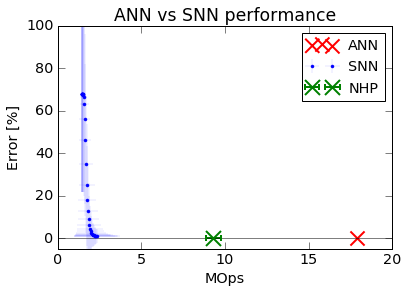

In [159]:
scale = 1e6  # Unit: Million operations
plt.errorbar(mean_c_t/scale, mean_error_t, xerr=std_c_t/scale, yerr=std_error_t, fmt='.', label='SNN (frame input)', capsize=0, elinewidth=0.1)
plt.errorbar(mean_c_t_poisson/scale, mean_error_t_poisson, xerr=std_c_t_poisson/scale, yerr=std_error_t_poisson, fmt='.', label='SNN (Poisson input)',
             capsize=0, elinewidth=0.1)
plt.scatter(c_ANN/scale, err_ANN, s=200, marker='x', label='ANN', color='red', linewidths=2)
plt.errorbar(c_NHP/scale, err_NHP, xerr=std_c_NHP/scale, fmt='x', label='NHP', markersize=15, elinewidth=2, capthick=2, markeredgewidth=2)
plt.hlines(0, 0, 20, linewidth=0.5)
plt.ylim(-5, 100)
plt.xlim(0, 20)
plt.ylabel('Error [%]')
plt.xlabel('MOps')
plt.legend()
plt.title('ANN vs SNN performance')
plt.savefig(os.path.join(settings['log_dir_of_current_run'], 'err_vs_ops'), bbox_inches='tight')

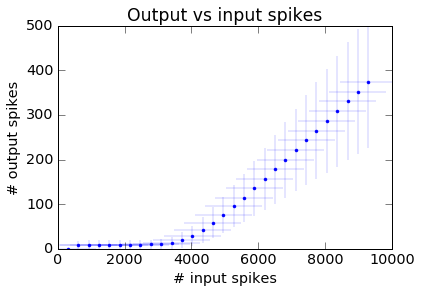

In [183]:
plt.errorbar(sin_t, sout_t, xerr=std_input_rate, yerr=s_samplestd[-1], fmt='.', capsize=0, elinewidth=0.2)
plt.ylabel('# output spikes')
plt.xlabel('# input spikes')
plt.title('Output vs input spikes')
plt.xlim(0, 10000)
plt.ylim(0, 500)
plt.savefig(os.path.join(settings['log_dir_of_current_run'], 'spikes_out_vs_in'), bbox_inches='tight')

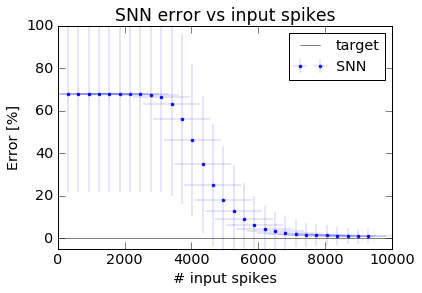

In [188]:
plt.errorbar(sin_t, mean_error_t, xerr=std_input_rate, yerr=std_error_t, fmt='.', capsize=0, elinewidth=0.2, label='SNN')
plt.hlines(0.1, 0, 10000, linewidth=0.5, label='target')
plt.ylim(-5, 100)
plt.xlim(0, 10000)
plt.ylabel('Error [%]')
plt.xlabel('# input spikes')
plt.title('SNN error vs input spikes')
plt.legend()
plt.savefig(os.path.join(settings['log_dir_of_current_run'], 'err_vs_inp'), bbox_inches='tight')

When using the DVS input directly, an increase in performance could be achieved by turning off reset between frames.
This has not helped when using frames as input. Reset of the membrane potential to zero after spikes also did not help.